# Sistem Rekomendasi : <span style="font-weight:normal">Rekomendasi Ponsel Seluler</span>
---

Proyek Submission 2 - Machine Learning Terapan

Oleh : Marwan Hadid

# Pendahuluan

Dataset ini merupakan kumpulan data ponsel seluler (cell phone) yang paling populer di Amerika Serikat pada tahun 2022. Dataset ini terdiri dari tiga berkas csv yang nantinya akan dibentuk menjadi sistem rekomendasi.

# Mengimport Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf

# Data Understanding

In [2]:
# Membaca dataset

data_file = 'cellphones data.csv'
rating_file = 'cellphones ratings.csv'
user_file = 'cellphones users.csv'

cellphone_df = pd.read_csv(data_file)
rating_df = pd.read_csv(rating_file)
user_df = pd.read_csv(user_file)

In [3]:
cellphone_df.head(5)

,cellphone_id,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date
0,0,Apple,iPhone SE (2022),iOS,128,4,7.23,12,7,2018,4.7,144,429,18/03/2022
1,1,Apple,iPhone 13 Mini,iOS,128,4,7.72,12,12,2438,5.4,141,699,24/09/2021
2,2,Apple,iPhone 13,iOS,128,4,7.75,12,12,3240,6.1,174,699,24/09/2021
3,3,Apple,iPhone 13 Pro,iOS,256,6,7.94,12,12,3065,6.1,204,999,24/09/2021
4,4,Apple,iPhone 13 Pro Max,iOS,256,6,8.01,12,12,4352,6.7,240,1199,24/09/2021


In [4]:
rating_df.head(5)

,user_id,cellphone_id,rating
0,0,30,1
1,0,5,3
2,0,10,9
3,0,9,3
4,0,23,2


In [5]:
user_df.head(5)

,user_id,age,gender,occupation
0,0,38,Female,Data analyst
1,1,40,Female,team worker in it
2,6,55,Female,IT
3,8,25,Female,Manager
4,10,23,Male,worker


In [6]:
print(f'Jumlah data ponsel selular :', cellphone_df.cellphone_id.nunique())
print(f'Jumlah data penilaian pengguna :', len(rating_df))
print(f'Jumlah data pengguna yang melakukan penilaian :', user_df.user_id.nunique())

Jumlah data ponsel selular : 33
Jumlah data penilaian pengguna : 990
Jumlah data pengguna yang melakukan penilaian : 99


In [7]:
cellphone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cellphone_id      33 non-null     int64  
 1   brand             33 non-null     object 
 2   model             33 non-null     object 
 3   operating system  33 non-null     object 
 4   internal memory   33 non-null     int64  
 5   RAM               33 non-null     int64  
 6   performance       33 non-null     float64
 7   main camera       33 non-null     int64  
 8   selfie camera     33 non-null     int64  
 9   battery size      33 non-null     int64  
 10  screen size       33 non-null     float64
 11  weight            33 non-null     int64  
 12  price             33 non-null     int64  
 13  release date      33 non-null     object 
dtypes: float64(2), int64(8), object(4)
memory usage: 3.7+ KB


Penjelasan Fitur:
- **cellphone_id**: nomor indeks unik pada setiap ponsel.
- **brand**: merek produsen setiap ponsel.
- **model**: tipe spesifik dari ponsel.
- **operating system**: sistem operasi pada ponsel.
- **internal memory**: ukuran memori internal yang tersedia dalam skala *giga byte* (GB).
- **RAM**: ukuran RAM pada ponsel dalam skala *giga byte* (GB).
- **performance**: rating performa ponsel berdasarkan skor *AnTuTu*.
- **main camera**: resolusi kamera utama (belakang) dalam skala megapiksel (MP).
- **selfie camera**: resolusi kamera *selfie* (depan) dalam skala megapiksel (MP).
- **battery size**: kapasitas baterai pada ponsel dalam miliamper perjam (mAh).
- **screen size**: ukuran ponsel dalam ukuran inci (*inches*).
- **weight**: berat ponsel dalam gram (g).
- **price**: harga ponsel dalam mata uang dollar (USD).
- **release date**: tanggal rilis ponsel

Jumlah fitur yang ada sebanyak 14, 8 diantaranya adalah numerik int64, 4 diantaranya adalah object, 2 sisanya adalah float64. Fitur **release date** merupakan kolom yang seharusnya bertipe waktu atau datetime.

In [8]:
print(f'Jumlah duplikasi :' ,cellphone_df.duplicated().sum())
print('Jumlah missing value :' ,cellphone_df.isnull().sum().sum())

Jumlah duplikasi : 0
Jumlah missing value : 0


In [9]:
for col in cellphone_df.columns:
    unique_values = cellphone_df[col].unique()
    print(f"Unique values in {col}: {unique_values}")

Unique values in cellphone_id: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Unique values in brand: ['Apple' 'Asus' 'Samsung' 'Google' 'OnePlus' 'Oppo' 'Vivo' 'Xiaomi' 'Sony'
 'Motorola']
Unique values in model: ['iPhone SE (2022)' 'iPhone 13 Mini' 'iPhone 13' 'iPhone 13 Pro'
 'iPhone 13 Pro Max' 'iPhone XR' 'Zenfone 8' 'Galaxy A13' 'Galaxy A32'
 'Galaxy A53' 'Galaxy S22' 'Galaxy S22 Plus' 'Galaxy S22 Ultra'
 'Galaxy Z Flip 3' 'Galaxy Z Fold 3' 'Pixel 6 \xa0' 'Pixel 6a'
 'Pixel 6 Pro\xa0' 'Nord N20' 'Nord 2T' '10 Pro' '10T' 'Find X5 Pro'
 'X80 Pro' 'Redmi Note 11' '11T Pro' '12 Pro' 'Poco F4' 'Xperia Pro'
 'Moto G Stylus (2022)' 'Moto G Play (2021)' 'Moto G Pure'
 'Moto G Power (2022)']
Unique values in operating system: ['iOS' 'Android']
Unique values in internal memory: [128 256  64  32 512]
Unique values in RAM: [ 4  6  3  8 12]
Unique values in performance: [ 7.23  7.72  7.75  7.94  8.01  4.22  6.76  1.36  2.2   3.79  8.81  7

Perlu perbaikan pada fitur model karena terdapat kesalahan penamaan pada beberapa model ponsel.

In [10]:
print(rating_df.nunique())
print('----------------------------------------')
rating_df.info()

user_id         99
cellphone_id    33
rating          11
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       990 non-null    int64
 1   cellphone_id  990 non-null    int64
 2   rating        990 non-null    int64
dtypes: int64(3)
memory usage: 23.3 KB


Terdapat 3 kolom pada berkas rating yaitu **user_id** sebagai nomer unik pengguna, **cellphone_id** sebagai nomer unik ponsel yang diberi nilai, dan **rating** sebagai skala nilai ponsel. Semua kolom bertipe numerik. Kolom **rating** memiliki anomali dimana seharusnya terdapat 10 nilai dalam skala 1 hingga 10.

In [11]:
print(rating_df['rating'].unique())

[ 1  3  9  2 10  8  7  5  6  4 18]


In [12]:
rating_df[rating_df['rating']== 18]

,user_id,cellphone_id,rating
943,254,26,18


Karena hanya terdapat 1 baris, data ini akan dihapus nantinya.

In [13]:
print(f'Jumlah duplikasi :' ,rating_df.duplicated().sum())
print('Jumlah missing value :' ,rating_df.isnull().sum().sum())

Jumlah duplikasi : 0
Jumlah missing value : 0


In [14]:
print(user_df.nunique())
print('----------------------------------------')
user_df.info()

user_id       99
age           30
gender         3
occupation    56
dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     99 non-null     int64 
 1   age         99 non-null     int64 
 2   gender      99 non-null     object
 3   occupation  98 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


Kolom **gender** dan **occupation** memiliki tipe data object sedangkan **age** dan **user_id** bertipe data numerik int64. Kolom **gender** seharusnya hanya memiliki dua nilai unik.

In [15]:
gender_col = user_df['gender'].unique()
print(gender_col)

['Female' 'Male' '-Select Gender-']


In [16]:
user_df[user_df['gender']== '-Select Gender-']

,user_id,age,gender,occupation
21,53,38,-Select Gender-,NaN
55,144,38,-Select Gender-,ADMINISTRATIVE OFFICER
64,169,38,-Select Gender-,Manager


In [17]:
print(f'Jumlah duplikasi :' ,user_df.duplicated().sum())
print('Jumlah missing value :' ,user_df.isnull().sum().sum())

Jumlah duplikasi : 0
Jumlah missing value : 1


Missing value dan invalid value pada gender akan dihapus pada data preprocessing.

# Data Preprocessing

In [18]:
df = pd.merge(rating_df, user_df, on='user_id', how='left')
df = pd.merge(df, cellphone_df, on='cellphone_id', how='left')
df = df.dropna()
df = df[df['gender'] != '-Select Gender-']
df = df[df['rating'] != 18]
df['occupation'] = df['occupation'].str.lower()
df['release_year'] = pd.to_datetime(df['release date'], format='%d/%m/%Y').dt.year
df = df.drop(['release date'], axis=1)

In [19]:
df['model'] = df['model'].str.replace(r'[\(\)\xa0\d]+', '').str.strip()
df['model'] = df['model'].str.extract(r'([^\(]*)')[0].str.strip()

In [20]:
print(df['model'].unique())

['Moto G Play' 'iPhone XR' 'Galaxy S22' 'Galaxy A53' 'X80 Pro'
 'Galaxy A32' 'Find X5 Pro' 'Pixel 6a' 'Nord 2T' 'iPhone 13 Pro'
 'Galaxy A13' 'Moto G Pure' 'Nord N20' 'Moto G Power' 'Xperia Pro'
 'Pixel 6' 'iPhone 13 Pro Max' 'Galaxy Z Flip 3' 'iPhone 13 Mini'
 'Poco F4' 'Moto G Stylus' '11T Pro' '10 Pro' 'iPhone SE'
 'Galaxy S22 Plus' 'Pixel 6 Pro' '10T' 'Zenfone 8' 'Galaxy Z Fold 3'
 'Galaxy S22 Ultra' 'Redmi Note 11' '12 Pro' 'iPhone 13']


In [21]:
df['gender'] = df['gender'].map({'Male' : 0, 'Female' : 1})
#df['operating system'] = df['operating system'].map({'Android' : 0, 'iOS' : 1})

In [22]:
df.head(5)

,user_id,cellphone_id,rating,age,gender,occupation,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release_year
0,0,30,1,38,1,data analyst,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021
1,0,5,3,38,1,data analyst,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,2018
2,0,10,9,38,1,data analyst,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,2022
3,0,9,3,38,1,data analyst,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,2022
4,0,23,2,38,1,data analyst,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,2022


# Data Visualization

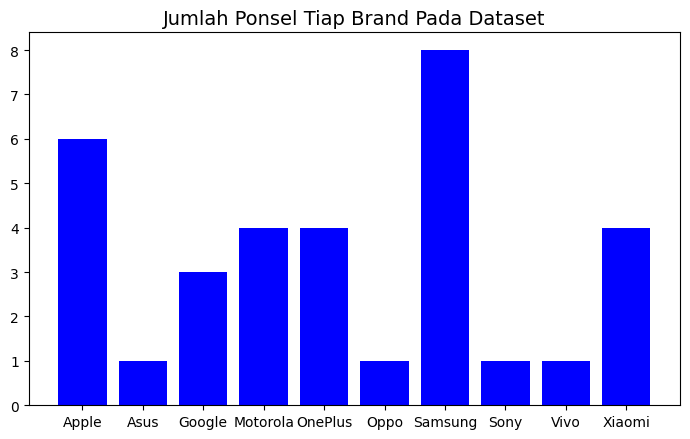

In [23]:
# Jumlah Ponsel Setiap Brand Pada Dataset
brand_model = cellphone_df.drop_duplicates(subset=['brand', 'model'], keep='first')

model_count = brand_model.groupby('brand')['model'].count().reset_index()

plt.figure(figsize=(7, 4.5))
plt.bar(model_count['brand'], model_count['model'], color='blue')
plt.title('Jumlah Ponsel Tiap Brand Pada Dataset', fontsize=14)
plt.tight_layout()
plt.savefig('jumlah_ponsel_tiap_brand.png')
plt.show()

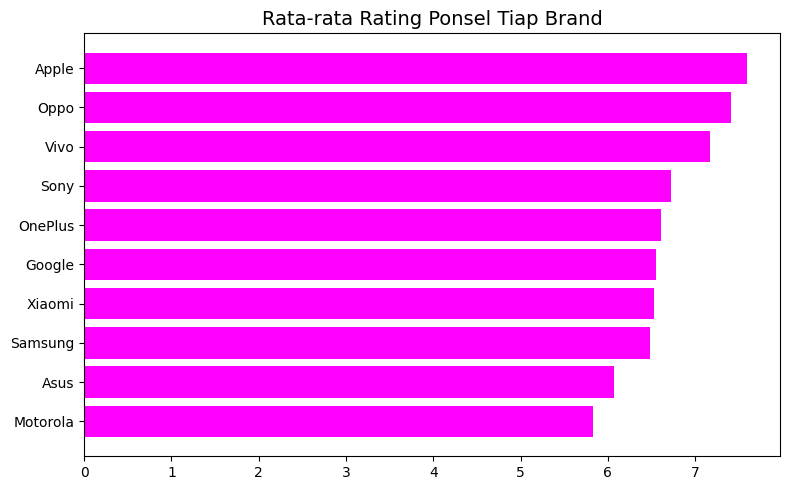

In [24]:
avg_rating_brand = df.groupby('brand')['rating'].mean().reset_index()

avg_rating_brand = avg_rating_brand.sort_values(by='rating', ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(avg_rating_brand['brand'], avg_rating_brand['rating'], color='magenta')
plt.title('Rata-rata Rating Ponsel Tiap Brand', fontsize=14)
plt.tight_layout()
plt.savefig('rata_rata_rating_tiap_brand.png')
plt.show()

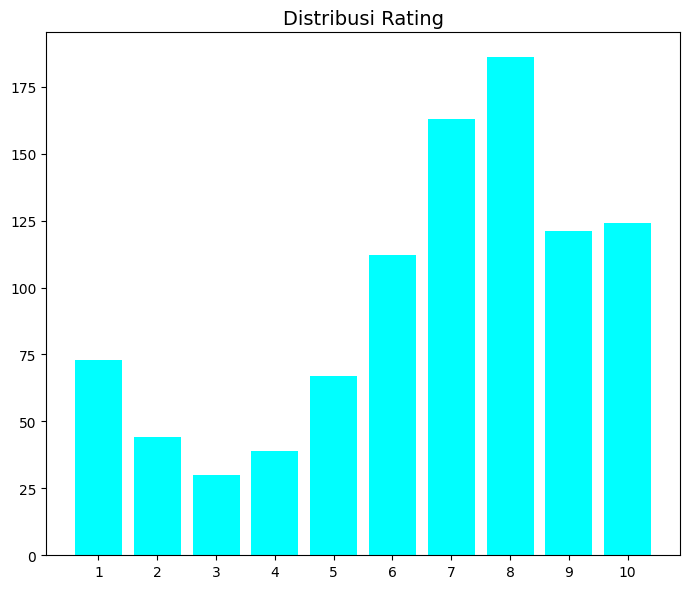

In [25]:
rating_counts = df['rating'].value_counts().sort_index()

plt.figure(figsize=(7,6))
plt.bar(rating_counts.index, rating_counts.values, color='cyan')
plt.title('Distribusi Rating', fontsize=14)
plt.xticks(rating_counts.index)
plt.tight_layout()
plt.savefig('distribusi_rating.png')
plt.show()

In [26]:
def wordcl(df, column):
    col = str(column)
    model_text = ' '.join(df[col])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(model_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

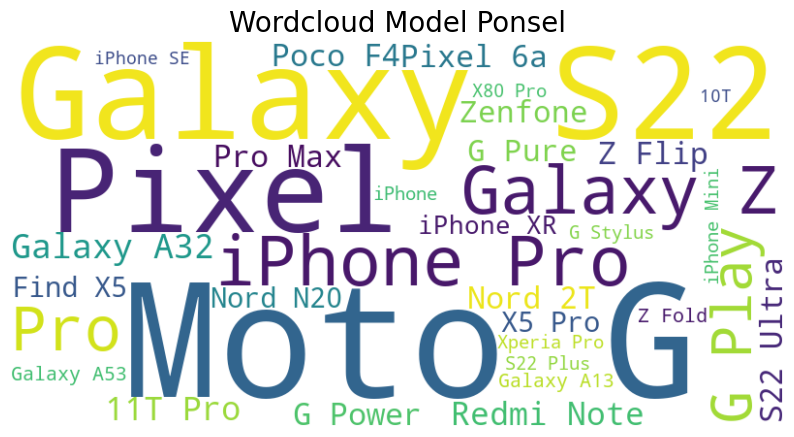

In [27]:
stopwords = set(["Pro", "Max", "Plus", "Lite", "Ultra"])
model_text = ' '.join([word for word in df['model'] if word not in stopwords])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(model_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud Model Ponsel', fontsize=20)
plt.axis('off')
plt.savefig('wordcloud_model_ponsel.png')
plt.show()

# Data Preparation

In [28]:
df = df.sort_values('user_id', ascending=True)
df.head(5)

,user_id,cellphone_id,rating,age,gender,occupation,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release_year
0,0,30,1,38,1,data analyst,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021
1,0,5,3,38,1,data analyst,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,2018
2,0,10,9,38,1,data analyst,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,2022
3,0,9,3,38,1,data analyst,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,2022
4,0,23,2,38,1,data analyst,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,2022


In [29]:
# Ponsel teratas berdasarkan rating dan harga
top_cellphones = df.sort_values(by=['rating', 'price'], ascending=[False, True]).drop_duplicates(subset=['brand'], keep='first').reset_index()
print("Top Cellphones by Rating and Price:")
print(top_cellphones[['brand', 'model', 'rating', 'price']].head(10))

Top Cellphones by Rating and Price:
      brand          model  rating  price
0  Motorola    Moto G Pure      10    129
1   Samsung     Galaxy A13      10    154
2    Xiaomi  Redmi Note 11      10    174
3     Apple      iPhone XR      10    236
4   OnePlus       Nord N20      10    299
5    Google       Pixel 6a      10    449
6      Asus      Zenfone 8      10    599
7      Vivo        X80 Pro      10    872
8      Oppo    Find X5 Pro      10    987
9      Sony     Xperia Pro      10   1998


## Content Based Filtering

In [30]:
df_prep = df.drop(['user_id','cellphone_id', 'occupation', 'gender', 'age'], axis=1)
df_prep.head(5)

,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release_year
0,1,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021
1,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,2018
2,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,2022
3,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,2022
4,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,2022


In [31]:
fitur = ['operating system', 'internal memory', 'RAM', 'main camera']

df_cbf = df_prep.copy()

def combine_features(row):
    return ' '.join([str(row[feature]) for feature in fitur])

df_cbf['combinedFeatures'] = df_cbf.apply(combine_features, axis=1)

print(df_cbf['combinedFeatures'].head())

0     Android 32 3 13
1         iOS 64 3 12
2    Android 128 8 50
3    Android 128 6 64
4    Android 256 8 50
Name: combinedFeatures, dtype: object


In [32]:
df_cbf.duplicated().sum()

670

In [33]:
df_cbf.drop_duplicates(subset=['model'], inplace=True)

In [34]:
cv = CountVectorizer()
cv_matrix = cv.fit_transform(df_cbf['combinedFeatures'])
print(cv_matrix.shape)

similarities_tfidf = cosine_similarity(cv_matrix)
print(similarities_tfidf.shape)

(33, 12)
(33, 33)


In [35]:
cosine_sim_df = pd.DataFrame(similarities_tfidf, index=df_cbf['model'], columns=df_cbf['model'])
print('Shape:', cosine_sim_df.shape)

print(cosine_sim_df.sample(4, axis=1).sample(8, axis=0))

Shape: (33, 33)
model          Galaxy A13  Galaxy S22 Plus   X80 Pro    10 Pro
model                                                         
Galaxy A32       0.333333         0.333333  0.333333  0.666667
Find X5 Pro      0.577350         0.577350  0.866025  0.288675
Moto G Power     0.666667         0.666667  0.666667  0.333333
Moto G Pure      0.666667         0.333333  0.333333  0.333333
Moto G Stylus    0.666667         1.000000  0.666667  0.666667
Poco F4          0.333333         0.666667  0.333333  0.666667
Pixel 6a         0.333333         0.666667  0.333333  0.666667
Pixel 6 Pro      0.577350         0.866025  0.577350  0.577350


Dataset untuk Content Based Filtering hanya memerlukan fitur-fitur yang berhubungan dengan spesifikasi ponsel.

## Collaborative Filtering

### Nearest Neighbors

In [36]:
knn_df = df.copy()

# Menghitung jumlah rating pada setiap ponsel
number_of_ratings = knn_df.groupby('cellphone_id')['rating'].count().reset_index()
number_of_ratings.rename(columns={'rating': 'number of cellphone-rating'}, inplace=True)

# Menggabungkan data dengan number_of_ratings
model_knn_df = knn_df.merge(number_of_ratings, on='cellphone_id')

model_knn_df.head(5)

,user_id,cellphone_id,rating,age,gender,occupation,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release_year,number of cellphone-rating
0,0,30,1,38,1,data analyst,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021,40
1,16,30,2,31,1,sales,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021,40
2,25,30,5,27,1,team leader,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021,40
3,32,30,1,39,0,qa software manager,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021,40
4,33,30,10,30,1,healthcare,Motorola,Moto G Play,Android,32,3,1.42,13,5,5000,6.5,204,159,2021,40


In [37]:
model_knn_df_pivot = model_knn_df.pivot_table(columns='user_id', index='cellphone_id', values='rating')
model_knn_df_pivot.fillna(0, inplace=True)

# Menyesuaikan ukuran matriks
model_knn_df_pivot = model_knn_df_pivot.astype(int)

model_knn_df_pivot.head(5)

user_id,0,1,6,8,10,12,16,24,25,26,...,245,246,251,252,253,254,255,256,257,258
cellphone_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,5,0,0,1,0,0,0,...,0,8,0,0,8,0,0,0,7,0
1,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,5,10,0,0,0
2,0,0,0,0,0,0,0,0,9,0,...,6,0,7,0,0,0,0,7,6,0
3,10,10,0,0,9,0,0,10,0,10,...,0,0,0,0,4,0,0,0,0,0
4,0,7,0,0,9,0,0,0,0,9,...,8,0,8,6,8,0,10,5,8,0


Dataset diubah menjadi pivot table. Dataset untuk KNN hanya memerlukan fitur-fitur yang berhubungan dengan rating ponsel.

### Deep Learning

In [38]:
dl_df = df.copy()

# Encode user_id dan cellphone_id
user_ids = dl_df["user_id"].unique().tolist()
user_to_user_encoded  = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user  = {i: x for i, x in enumerate(user_ids)}

cellphone_ids = dl_df["cellphone_id"].unique().tolist()
cellphone_to_cellphone_encoded  = {x: i for i, x in enumerate(cellphone_ids)}
cellphone_encoded_to_cellphone  = {i: x for i, x in enumerate(cellphone_ids)}

dl_df["user"] = dl_df["user_id"].map(user_to_user_encoded)
dl_df["cellphone"] = dl_df["cellphone_id"].map(cellphone_to_cellphone_encoded)

num_users = len(user_to_user_encoded)
num_cellphones = len(cellphone_encoded_to_cellphone)

dl_df["rating"] = dl_df["rating"].values.astype(np.float32)

min_rating = min(dl_df["rating"])
max_rating = max(dl_df["rating"])

print("Number of users: {}, Number of Books: {}, Min rating: {}, Max rating: {}".format(num_users, num_cellphones, min_rating, max_rating))

Number of users: 96, Number of Books: 33, Min rating: 1.0, Max rating: 10.0


In [39]:
model_dl_df = dl_df.sample(frac=1, random_state=42)
model_dl_df.head(5)

,user_id,cellphone_id,rating,age,gender,occupation,brand,model,operating system,internal memory,...,performance,main camera,selfie camera,battery size,screen size,weight,price,release_year,user,cellphone
860,242,24,4.0,35,0,healthare,Xiaomi,Redmi Note 11,Android,128,...,2.44,50,13,5000,6.4,179,174,2022,83,30
484,126,4,9.0,27,1,information technology,Apple,iPhone 13 Pro Max,iOS,256,...,8.01,12,12,4352,6.7,240,1199,2021,47,10
366,106,18,5.0,32,0,manager,OnePlus,Nord N20,Android,128,...,3.80,64,16,4500,6.4,173,299,2022,35,14
927,252,25,7.0,58,0,administrative officer,Xiaomi,11T Pro,Android,256,...,7.59,108,16,5000,6.6,204,435,2021,89,24
884,244,25,9.0,41,0,manager,Xiaomi,11T Pro,Android,256,...,7.59,108,16,5000,6.6,204,435,2021,85,24


In [40]:
x = model_dl_df[["user", "cellphone"]].values

# Target variable
y = model_dl_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split data menjadi train dan test
train_indices = int(0.7 * model_dl_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((671, 2), (288, 2), (671,), (288,))

Dataset untuk Deep Learning hanya memerlukan fitur-fitur yang berhubungan dengan rating ponsel. Dataset akan dibagi sebanyak 70% untuk data training dan 30% untuk data testing.

# Model Development

## Content Based Filtering

In [41]:
def phone_recommendations(model_name, similarity_data=cosine_sim_df, items=df_cbf[fitur + ['model']], k=5):
    index = similarity_data.loc[:, model_name].to_numpy().argpartition(range(-1, -k-1, -1))

    closest = similarity_data.columns.to_numpy()[index[-1:-(k+2):-1]]

    closest = np.ravel(closest)

    closest = [phone for phone in closest if phone != model_name]

    result_df = pd.DataFrame(closest, columns=['model']).merge(items, on='model').head(k)

    similarity_scores = similarity_data.loc[model_name, result_df['model']]
    result_df['score'] = similarity_scores.values

    return result_df[fitur + ['model', 'score']]

model_name = '10T'  # Sesuaikan dengan nama model yang ingin direkomendasikan
num_rec = 5  # Jumlah Rekomendasi
phone_recommendations_df = phone_recommendations(model_name, k=num_rec)

print(f"Top {num_rec} Rekomendasi ponsel berdasarkan model {model_name}:")
print(phone_recommendations_df)

Top 5 Rekomendasi ponsel berdasarkan model 10T:
  operating system  internal memory  RAM  main camera            model  score
0          Android              128    8           50          Pixel 6    1.0
1          Android              128    8           50          Nord 2T    1.0
2          Android              128    8           50  Galaxy S22 Plus    1.0
3          Android              128    6           50    Moto G Stylus    1.0
4          Android              128    8           50           12 Pro    1.0


In [42]:
print(model_name)
print(df_cbf[df_cbf.model.eq(model_name)][fitur])

10T
   operating system  internal memory  RAM  main camera
38          Android              128    8           50


Fitur untuk content based filtering dapat ditambah maupun dikurangi pada variabel fitur.

Hasil dari Content Based Filtering adalah rekomendasi ponsel berdasarkan fitur-fitur yang dimiliki oleh ponsel yang dipilih.

## Collaborative Filtering

### Nearest Neighbors

In [43]:
# Inisialisasi model KNN
model_knn_cellphone = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn_cellphone.fit(model_knn_df_pivot)

NearestNeighbors(algorithm='brute', metric='cosine')

In [44]:
cellphone_df_name = pd.DataFrame({'Cellphone': model_knn_df_pivot.index})

cellphone_df_name.duplicated().sum()

0

In [45]:
# Fungsi untuk mendapatkan rekomendasi
def recommend_cellphone(cellphone_name):
    cellphone_id = np.where(model_knn_df_pivot.index == cellphone_name)[0][0]
    distances, recommendations = model_knn_cellphone.kneighbors(model_knn_df_pivot.iloc[cellphone_id, :].values.reshape(1, -1), n_neighbors=11)

    cellphone = []
    distance = []

    for i in range(0, len(distances.flatten())):
        if i != 0:
            recommended_cellphone_id = model_knn_df_pivot.index[recommendations.flatten()[i]]
            recommended_cellphone_name = model_knn_df[model_knn_df['cellphone_id'] == recommended_cellphone_id]['model'].values[0]
            cellphone.append(recommended_cellphone_name)
            distance.append(distances.flatten()[i])

    c = pd.Series(cellphone, name='cellphone')
    d = pd.Series(distance, name='distance')
    recommendations_df = pd.concat([c, d], axis=1)
    recommendations_df = recommendations_df.sort_values('distance', ascending=False)

    print(f'10 Rekomendasi untuk ponsel {model_knn_df[model_knn_df["cellphone_id"] == cellphone_name]["model"].values[0]} sebagai berikut :\n')
    for i in range(0, recommendations_df.shape[0]):
        print('{0}: {1}, with distance of {2}'.format(i, recommendations_df["cellphone"].iloc[i], recommendations_df["distance"].iloc[i]))

In [46]:
cellphone_name = cellphone_df_name.iloc[28][0]
recommend_cellphone(cellphone_name)

10 Rekomendasi untuk ponsel Xperia Pro sebagai berikut :

0: Nord N20, with distance of 0.7391863503412192
1: Find X5 Pro, with distance of 0.7221312781196743
2: 10T, with distance of 0.706235262124101
3: Redmi Note 11, with distance of 0.6847865811144636
4: Moto G Pure, with distance of 0.6800465276651233
5: Pixel 6a, with distance of 0.6640232136428437
6: Moto G Play, with distance of 0.6449885098433434
7: Pixel 6, with distance of 0.620879067430839
8: X80 Pro, with distance of 0.5922716936733281
9: Galaxy A13, with distance of 0.5309814131625528


Collaborative Filtering menggunakan metode Nearest Neighbors untuk mendapatkan rekomendasi ponsel berdasarkan rating yang diberikan oleh pengguna.

### Deep Learning

In [47]:
# Recommender system deep learning
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_cellphones, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_cellphones = num_cellphones
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1)
        self.cellphone_embedding = tf.keras.layers.Embedding(
            num_cellphones,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.cellphone_bias = tf.keras.layers.Embedding(num_cellphones, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        cellphone_vector = self.cellphone_embedding(inputs[:, 1])
        cellphone_bias = self.cellphone_bias(inputs[:, 1])
        dot_user_cellphone = tf.tensordot(user_vector, cellphone_vector, 2)
        # Add all the components (including bias)
        x = dot_user_cellphone + user_bias + cellphone_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [48]:
model = RecommenderNet(num_users, num_cellphones, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [49]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/100
84/84 [==============================] - 5s 14ms/step - loss: 0.7244 - root_mean_squared_error: 0.3440 - val_loss: 0.7464 - val_root_mean_squared_error: 0.3390
Epoch 2/100
84/84 [==============================] - 1s 11ms/step - loss: 0.7129 - root_mean_squared_error: 0.3347 - val_loss: 0.7445 - val_root_mean_squared_error: 0.3371
Epoch 3/100
84/84 [==============================] - 1s 11ms/step - loss: 0.6807 - root_mean_squared_error: 0.3120 - val_loss: 0.7423 - val_root_mean_squared_error: 0.3354
Epoch 4/100
84/84 [==============================] - 1s 10ms/step - loss: 0.6856 - root_mean_squared_error: 0.3154 - val_loss: 0.7415 - val_root_mean_squared_error: 0.3342
Epoch 5/100
84/84 [==============================] - 1s 11ms/step - loss: 0.6657 - root_mean_squared_error: 0.3011 - val_loss: 0.7401 - val_root_mean_squared_error: 0.3332
Epoch 6/100
84/84 [==============================] - 1s 11ms/step - loss: 0.6578 - root_mean_squared_error: 0.2961 - val_loss: 0.7389 - val_

In [50]:
# Pembuatan dataframe untuk ponsel
phone_df = pd.DataFrame({
    'cellphone_id': dl_df['cellphone_id'],
    'Model': dl_df['model'],
    'Brand': dl_df['brand'],
})

phone_df.duplicated().sum()

926

In [51]:
phone_df.drop_duplicates(inplace=True)

In [52]:
phone_df.head(5)

,cellphone_id,Model,Brand
0,30,Moto G Play,Motorola
1,5,iPhone XR,Apple
2,10,Galaxy S22,Samsung
3,9,Galaxy A53,Samsung
4,23,X80 Pro,Vivo


In [53]:
# Top rekomendasi ponsel untuk random user
user_id = dl_df.user_id.sample(10).iloc[0]
cellphones_rated_by_user = dl_df[dl_df.user_id == user_id]
cellphones_not_rated = phone_df[~phone_df['cellphone_id'].isin(cellphones_rated_by_user.cellphone_id.values)]['cellphone_id']
cellphones_not_rated = list(
    set(cellphones_not_rated).intersection(set(dl_df['cellphone_id']))
)

cellphones_not_rated = [[cellphone_to_cellphone_encoded.get(x)] for x in cellphones_not_rated]

user_encoder = user_to_user_encoded.get(user_id)

user_cellphone_array = np.hstack(
    ([[user_encoder]] * len(cellphones_not_rated), cellphones_not_rated)
)

In [54]:
ratings = model.predict(user_cellphone_array).flatten()

1/1 [==============================] - 0s 105ms/step


In [55]:
top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_cellphone_ids = [
    cellphone_encoded_to_cellphone.get(cellphones_not_rated[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Cellphones with high ratings from user")
print("----" * 8)

top_cellphones_user = (
    cellphones_rated_by_user.sort_values(
        by='rating',
        ascending=False)
    .head(5)
    .cellphone_id.values
)

cellphone_df_rows_user = phone_df[phone_df["cellphone_id"].isin(top_cellphones_user)]
for row in cellphone_df_rows_user.itertuples():
    print(row.Model, ":", row.Brand)

print("----" * 8)
print("Top 10 Cellphones recommendations")
print("----" * 8)

recommended_cellphones = phone_df[phone_df["cellphone_id"].isin(recommended_cellphone_ids)]
for row in recommended_cellphones.itertuples():
    print(row.Model, ":", row.Brand)

Showing recommendations for user: 255
Cellphones with high ratings from user
--------------------------------
iPhone 13 Pro Max : Apple
Galaxy Z Flip 3 : Samsung
11T Pro : Xiaomi
Galaxy Z Fold 3 : Samsung
Zenfone 8 : Asus
--------------------------------
Top 10 Cellphones recommendations
--------------------------------
iPhone XR : Apple
Galaxy S22 : Samsung
X80 Pro : Vivo
Find X5 Pro : Oppo
iPhone 13 Pro : Apple
Pixel 6 : Google
Xperia Pro : Sony
Pixel 6 Pro : Google
10 Pro : OnePlus
iPhone 13 : Apple


# Model Evaluation

## Collaborative Filtering Deep Learning

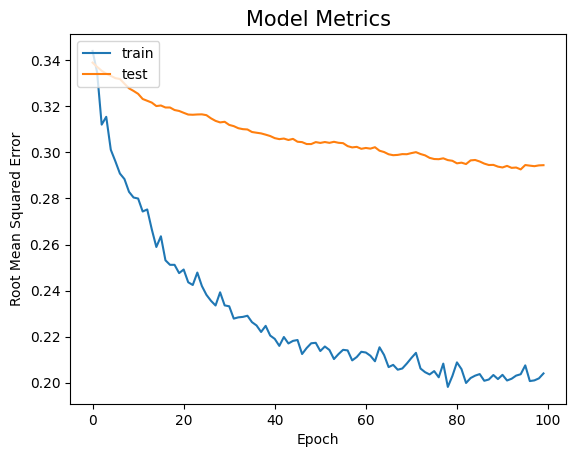

In [56]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics', fontsize=15)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('figure.png')
plt.show()

In [57]:
model.evaluate(x,y)

30/30 [==============================] - 0s 3ms/step - loss: 0.7726 - root_mean_squared_error: 0.3281


[0.7725903987884521, 0.32812440395355225]

Pada pembuatan proyek ini metrik evaluasi yang digunakan yaitu root mean squared error (RMSE). Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.2040 dan error pada data validasi sebesar 0.2944. Nilai tersebut cukup bagus untuk sistem rekomendasi.

Setelah dilakukan evaluasi menggunakan seluruh data memperoleh nilai error sebesar 0.3281.